<h3> Metody do przewidywania tagów POS - zestawienie

In [1]:
from nltk.corpus import treebank 

train_set =  treebank.tagged_sents()[:3000]
test_set =   treebank.tagged_sents()[3000:]

<h4> HMM

In [2]:
#HMM Hidden Markov Models, tradycyjny ukryty model Markowa, stan następny jest generowany na podstawie stanu poprzedniego
from nltk.tag import hmm

HMM_model = hmm.HiddenMarkovModelTrainer() 
HMM_tagger = HMM_model.train_supervised(train_set)
print("Na zbiorze testowym:", HMM_tagger.evaluate(test_set))

Na zbiorze testowym: 0.36844377293330455


<h4> TnT

In [3]:
#TnT = Trigrams'n'Tags, jest także metodą typu HMM, jednak tym razem stan następny generowany jest na podstawie [[dwoch]] poprzednich stanow. Ponadto wyposazony jest w metody wygładzania (smoothing), nieznane slowa obsługiwane są przy pomocy drzew sufiksowych 
from nltk.tag import tnt

TnT_model = tnt.TnT()
TnT_model.train(train_set)
print("Na zbiorze testowym: ", TnT_model.evaluate(test_set))

Na zbiorze testowym:  0.875545003237643


<h4> CRF

In [4]:
#CRF = Conditional Random Fields, używa dodatkowych funkcji modyfikujacych prawdopodobieństwa stanów, optymalne rozwiązanie uzyskuje się przez zastosowanie algorytmu podobnego do algorytmu Viterbiego
from nltk.tag import CRFTagger

CRF_model = CRFTagger()
CRF_model.train(train_set, 'crf_tagger_model')
print("Na zbiorze testowym:",CRF_model.evaluate(test_set))

Na zbiorze testowym: 0.9474638463198791


<h4> Sieci neuronowe

In [5]:
#Rozwiązanie przy pomocy sieci neuronowych, inna idea niz w przypadku trzech poprzednich metod, o sieciach neuronowych jeszcze będzie w przyszlosci :)
from nltk.tag.perceptron import PerceptronTagger

PER_model = PerceptronTagger(load = False)
PER_model.train(train_set)
print("Na zbiorze testowym:",PER_model.evaluate(test_set))

Na zbiorze testowym: 0.957435786747248


<h3> Zastosowanie Twierdzenia Bayesa do klasyfikacji recenzji filmowych


Ogólny schemat klasyfikacji:

- mamy pewne dane (zbiór tekstów) oraz kategorie do których należą
- dzielimy dane na dwie części: zbiór treningowy i zbiór testowy
- uczymy model na zbiorze treningowym (model wie który tekst należy do której kategorii)
- testujemy model na zbiore testowym (model nie wie do jakiej kategorii należą nowe teksty - ma to przewidzieć)
- porównujemy zdolności predykacyjne modelu z tym jak jest (np przy użyciu parametru dokładności).

In [6]:
import nltk

In [7]:
from nltk.corpus import movie_reviews #korpus z recenzjami - 1000 poztytywnych i 1000 negatywnych

In [8]:
movie_reviews.categories()

['neg', 'pos']

In [9]:
print(movie_reviews.fileids()[990:1010]) #1000 recenzji pozytywnych i 1000 recenzji negatywnych

['neg/cv990_12443.txt', 'neg/cv991_19973.txt', 'neg/cv992_12806.txt', 'neg/cv993_29565.txt', 'neg/cv994_13229.txt', 'neg/cv995_23113.txt', 'neg/cv996_12447.txt', 'neg/cv997_5152.txt', 'neg/cv998_15691.txt', 'neg/cv999_14636.txt', 'pos/cv000_29590.txt', 'pos/cv001_18431.txt', 'pos/cv002_15918.txt', 'pos/cv003_11664.txt', 'pos/cv004_11636.txt', 'pos/cv005_29443.txt', 'pos/cv006_15448.txt', 'pos/cv007_4968.txt', 'pos/cv008_29435.txt', 'pos/cv009_29592.txt']


In [10]:
documents = [] #tworze pustą liste, bede tu zapisywal slowa z kolejnych recenzji oraz kategorię do jakiej ta recenzja nalezy

for category in movie_reviews.categories(): #dla kazdej z kategorii (pos/neg)
    for fileid in movie_reviews.fileids(category): #dla wszytkich recenzji z danej kategorii
        documents.append((list(movie_reviews.words(fileid)), category)) #dodaj element typu ([ slowa z recenzji], 'pos/neg')

In [11]:
print(documents[0]) #zobaczmy jak wyglada pierwsza recenzja zapisana do documents w tym formacie                 

(['plot', ':', 'two', 'teen', 'couples', 'go', 'to', 'a', 'church', 'party', ',', 'drink', 'and', 'then', 'drive', '.', 'they', 'get', 'into', 'an', 'accident', '.', 'one', 'of', 'the', 'guys', 'dies', ',', 'but', 'his', 'girlfriend', 'continues', 'to', 'see', 'him', 'in', 'her', 'life', ',', 'and', 'has', 'nightmares', '.', 'what', "'", 's', 'the', 'deal', '?', 'watch', 'the', 'movie', 'and', '"', 'sorta', '"', 'find', 'out', '.', '.', '.', 'critique', ':', 'a', 'mind', '-', 'fuck', 'movie', 'for', 'the', 'teen', 'generation', 'that', 'touches', 'on', 'a', 'very', 'cool', 'idea', ',', 'but', 'presents', 'it', 'in', 'a', 'very', 'bad', 'package', '.', 'which', 'is', 'what', 'makes', 'this', 'review', 'an', 'even', 'harder', 'one', 'to', 'write', ',', 'since', 'i', 'generally', 'applaud', 'films', 'which', 'attempt', 'to', 'break', 'the', 'mold', ',', 'mess', 'with', 'your', 'head', 'and', 'such', '(', 'lost', 'highway', '&', 'memento', ')', ',', 'but', 'there', 'are', 'good', 'and', 'b

In [12]:
import random #biblioteka do operacji na liczbach losowych czy tasowania danych

random.shuffle(documents) #tasuje kolejnosc w liscie documents, bo poki co pierwsze 1000 to neg, a kolejny 1000 to pos, a chce miec losowe ulozenie recenzji

In [13]:
all_words = [] #tu będą wszystkie slowa występujące we wszystkich recenzjach

for w in movie_reviews.words():  #dla wszystkich slow ze wszystkich dokumentow korpusu movie_reviews
    all_words.append(w.lower())  #dodaje do listy all_words slowa zapisane z malej litery

In [14]:
all_words = nltk.FreqDist(all_words) #liczę częstosci slow i nadpisuje zmienną all_words

In [15]:
all_words.most_common(5) #5 najpopularniejszych slow

[(',', 77717), ('the', 76529), ('.', 65876), ('a', 38106), ('and', 35576)]

In [16]:
all_words["stupid"] #ile razy wystąpilo slowo stupid

253

In [17]:
all_words["interesting"] 

638

In [18]:
all_words["boring"]

270

In [19]:
len(all_words) #ile wystapilo wszystkich slow

39768

In [20]:
word_features = [x[0] for x in all_words.most_common(3000)] #do zmiennej word_features zapisuje pierwsze 3000 najczęstszych slow

In [21]:
#Tworze funkcje, ktorej argumentami będzie lista wyrazow, a ktora będzie wywolywana dla kolejnych recenzji, będe sprawdzal czy występują w niej slowa z word_features

def find_features(document): #przez document rozumiemy tutaj lista wyrazow
    words = set(document)    #patrze na unikatowe slowa
    features = {}            #tworzę pusty slownik
    for w in word_features: #word_features zdefiniowane wyzej [lista 3000 najczęstych slow we wszystkich recenzjach]
        features[w] = (w in words) #True or False, dla kazdego slowa z word_features w zaleznosci czy jest czy nie w dokumencie
    return features

In [22]:
#Przykładowe wywołanie funkcji 
ex_r = movie_reviews.words('neg/cv000_29416.txt') #przykladowa recenzja

print(find_features(ex_r)['plot']) #czy slowo 'plot' wsytapilo w tej recenzji?
print(find_features(ex_r)['funny']) #czy slowo 'funny' wystapilo w tej recenzji?

True
False


In [23]:
featuresets = [(find_features(rev),category) for (rev,category) in documents] #zapisuje liste krotek (slownik jak wyzej, pos/neg)

In [24]:
training_set = featuresets[:1900] #jako zbior treningowy biorę pierwsze 1900 recenzji
testing_set = featuresets[1900:]  #jako zbior tetowy biorę pozostałe recenzje

In [25]:
#wykonuje algorytm Naive Bayes na zbiorze treningowym

classifier = nltk.NaiveBayesClassifier.train(training_set)

In [26]:
#testuje model na zbiorze testowym

print("Dokładność metody Naive Bayes do problemu klasfyikacji na zbiorze testowym wynosi:", (nltk.classify.accuracy(classifier,testing_set))*100)

Dokładność metody Naive Bayes do problemu klasfyikacji na zbiorze testowym wynosi: 76.0


In [27]:
classifier.show_most_informative_features(15) #jakie bylo 15 najbardziej rozstrzygających slow

Most Informative Features
             outstanding = True              pos : neg    =     10.6 : 1.0
                   mulan = True              pos : neg    =      9.0 : 1.0
                  seagal = True              neg : pos    =      7.8 : 1.0
                  finest = True              pos : neg    =      7.7 : 1.0
             wonderfully = True              pos : neg    =      7.6 : 1.0
              schumacher = True              neg : pos    =      7.4 : 1.0
                 idiotic = True              neg : pos    =      7.3 : 1.0
                   damon = True              pos : neg    =      6.3 : 1.0
                religion = True              pos : neg    =      6.1 : 1.0
             beautifully = True              pos : neg    =      6.1 : 1.0
                   awful = True              neg : pos    =      5.9 : 1.0
                   jolie = True              neg : pos    =      5.8 : 1.0
                   flynt = True              pos : neg    =      5.6 : 1.0

<h4> Zadanie1: Czy fakt, że nie oczyściliśmy danych ze stopwords czy znaków interpunkcyjncyh znacząco wpłynął na pogorszenie predykcji? Odpowiedź uzasadnij (bez obliczeń, chodzi o 2 zdania komentarza).

<h4> Zadanie2: Powtórz 20 razy predykcję za pomocą metody Naive Bayes za każdym razem tasując listę documents (po co?). Zapisz do listy dokładności uzyskane za każdym razem. Wyznacz średnią dokładność i odchylenie standardowe z tych dokładności (wcześniej przerób listę na obiekt typu array). Narysuj histogram dokładności.

<h4> Zadanie3: Wyjaśnij czemu istotnym jest aby grupy tekstów reprezentujących klasy były w miarę równoliczne. Zbuduj model NaiveBayes, gdzie jako zbiór treningowy wybierz 900 recenzji pozytywnych i 100 negatywnych. Następnie zabadaj jak model sprawdza się na 100 pozostałych recenzjach pozytywnych a jak na 100 negatywnych (innych niż przy trenowaniu modelu). Skomentuj otrzymane wyniki.

<h4> Zadanie4: Zbuduj model do predykcji wiadomości SPAM/HAM. W tym celu użyj pliku  spam_ham.txt . Każda wiadomość opatrzona jest odpowiednim tagiem na początku kolejnego wiersza. Sprawdź ile w pliku znajduje się wiadomości typu SPAM i HAM. Uwzględnij uwagę z poprzedniego zadania.

<h3> Serializacja (zapisywanie obiektu)


In [28]:
import pickle

t = [1,2,3,4,5]

#zapisywanie listy [jako obiektu!!!] do pliku 
save_list = open("my_list.pickle","wb") #w-write, b -bity
pickle.dump(t, save_list)
save_list.close()

In [29]:
#otwieranie
f = open("my_list.pickle","rb")
moja_lista = pickle.load(f) 
f.close()

In [30]:
print(moja_lista)

[1, 2, 3, 4, 5]


<h4> Zadanie5: Zapisz do pliku utworzony poprzednio model (znajdujący się w pod zmienną  $classifier$).

<h3> Uzupełnienie: Elementy statystyki i prezentacji danych

In [31]:
import numpy as np #biblioteka obiektow typu array i pozwalająca przeprowadzic operacje na nich

x = np.array([1,2,5,6,2,2,4,1,5,5,3,3,4,5,6]) #nowy typ danych, cos jak lista ale ma nowe metody, będzie jeszcze o tym w przyszlosci

In [32]:
type(x) #jaki typ

numpy.ndarray

In [33]:
x[-1] #ostatni element

6

In [34]:
x[0:4] #elementy 0,1,2,3

array([1, 2, 5, 6])

In [36]:
np.mean(x) #średnia

3.6

In [37]:
np.median(x) #mediana

4.0

In [38]:
np.sum(x)  #suma elementow

54

<h4> Porównanie obiektów typu listy i array


In [39]:
x = [1,2,3]
y = [4,5,6]

print(x+y)
print(3*x)

[1, 2, 3, 4, 5, 6]
[1, 2, 3, 1, 2, 3, 1, 2, 3]


In [40]:
x = np.array([1,2,3])
y = np.array([4,5,6])

print(x+y)
print(3*x)

[5 7 9]
[3 6 9]


In [41]:
#Z obiektem typu array moge zrobic cos czego z listą absolutnie mi nie wolno

x = np.array([1,2,3,4,5])
y = x**2 + np.sin(x)
print(y)

[ 1.84147098  4.90929743  9.14112001 15.2431975  24.04107573]


<h4> Rysowanie wykresów


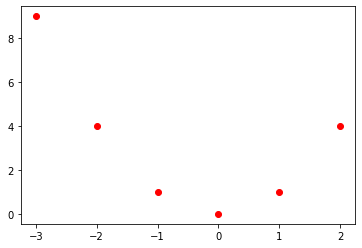

In [42]:
import matplotlib.pyplot as plt #biblioteka do rysowania wykresow

a = np.array([-3,-2,-1,0,1,2])
b = a**2

#Rysowanie
plt.scatter(a,b, c = "red") #to samo co wyzej, tyle ze tym razem nie łączy punktow
plt.show()

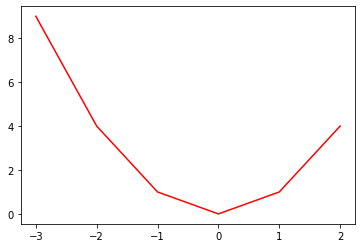

In [43]:
plt.plot(a,b, c = "red") #to samo co wyzej, tyle ze tym razem łączy punkty
plt.show()

In [44]:
x =  np.random.rand(1000) #generuje 1000 liczb z rozkładu jednostajnego
y =  np.random.randn(1000) #generuje 1000 liczb z rozkładu normalnego (Gaussa)

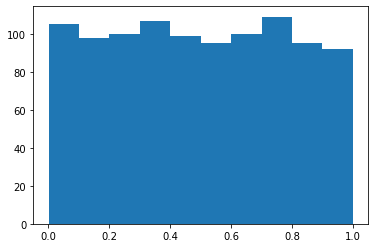

In [45]:
#Rysuje histogram dla x
plt.hist(x)
plt.show()

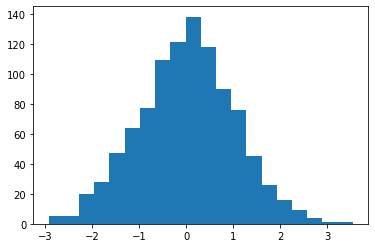

In [46]:
#Rysuje histogram dla y
plt.hist(y, bins = 20) #parametr bins - ile pudełek ma być widocznych na rysunku
plt.show()

<h3> Uzupełnienie: przetwarzanie języka polskiego

Tutaj można pobrać: http://zil.ipipan.waw.pl/SpacyPL

In [1]:
import spacy #biblioteka do przetwarzania języka naturalnego, cos jak nltk
nlp = spacy.load('pl_spacy_model')

In [2]:
zdanie = nlp("Tam jest biały pies")
print(zdanie)

Tam jest biały pies


In [3]:
for token in zdanie:
    print(token.text, token.lemma_, token.pos_) 

Tam tam ADV
jest być VERB
biały biały ADJ
pies pies NOUN


In [4]:
[token.text for token in zdanie] #same tokeny 

['Tam', 'jest', 'biały', 'pies']

In [5]:
from spacy import displacy
displacy.render(zdanie, style="dep")

In [6]:
displacy.render(zdanie, style = 'dep', options = {"compact": True})

In [7]:
doc = nlp("Nazywam się Michał Żak. \
        Mam 28 lat i urodziłem się w Krakowie 7 września 2002.") 

for entity in doc.ents:
    print(entity.text, entity.label_)

Michał Żak persName
Krakowie placeName
7 września 2002 date
